In [18]:
import json

# Load train.json and val.json
with open('train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open('val.json', 'r', encoding='utf-8') as f:
    val_data = json.load(f)

print("Train data sample:", train_data[0])
print("Validation data sample:", val_data[0])

Train data sample: {'sentence_id': '3121', 'sentence': 'But the staff was so horrible to us.', 'aspect_terms': [{'term': 'staff', 'polarity': 'negative', 'from': '8', 'to': '13'}], 'aspect_categories': [{'category': 'service', 'polarity': 'negative'}]}
Validation data sample: {'sentence_id': '3510', 'sentence': 'I was here a few weeks back and we had the worst customer service experience at a restaurant ever.', 'aspect_terms': [{'term': 'customer service', 'polarity': 'negative', 'from': '49', 'to': '65'}], 'aspect_categories': [{'category': 'anecdotes/miscellaneous', 'polarity': 'negative'}, {'category': 'service', 'polarity': 'negative'}]}


# preprocessing the data

In [19]:
import json

def tokenize(sentence):
    """Tokenizes the sentence by spaces while keeping punctuation attached to words."""
    return sentence.split()

def apply_bio_encoding(sentence, aspect_terms):
    """Applies BIO encoding to the tokenized sentence based on aspect term positions."""
    tokens = tokenize(sentence)
    labels = ['O'] * len(tokens)  # Default all labels to 'O'

    # Convert character positions to token indices
    token_offsets = []
    offset = 0
    for token in tokens:
        token_offsets.append((offset, offset + len(token)))
        offset += len(token) + 1  # +1 for space

    for aspect in aspect_terms:
        aspect_text = aspect['term']
        aspect_start = int(aspect['from'])
        aspect_end = int(aspect['to'])
        found_first = False

        # Find the matching tokens
        for i, (start, end) in enumerate(token_offsets):
            if start < aspect_end and end > aspect_start: # Token overlaps with aspect term
                if not found_first:
                    labels[i] = 'B'
                    found_first = True
                else:
                    labels[i] = 'I'

    return tokens, labels

def process_file(input_file, output_file):
    """Processes the input JSON file and saves the preprocessed output."""
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    processed_data = []

    for entry in data:
        processed_entry = {
            'sentence': entry['sentence'],
            'tokens': [],
            'labels': [],
            'aspect_terms': [aspect['term'] for aspect in entry['aspect_terms']]
        }

        tokens, labels = apply_bio_encoding(entry['sentence'], entry['aspect_terms'])
        processed_entry['tokens'] = tokens
        processed_entry['labels'] = labels

        processed_data.append(processed_entry)

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(processed_data, f, indent=4)

# Process training and validation files
process_file('train.json', 'train_task_1.json')
process_file('val.json', 'val_task_1.json')

print("Processing complete! Saved to processed_train_task_1.json and processed_val_task_1.json")

Processing complete! Saved to processed_train_task_1.json and processed_val_task_1.json


In [3]:
# Load and print a sample from the preprocessed data
with open('train_task_1.json', 'r', encoding='utf-8') as f:
    train_preprocessed = json.load(f)

print("Sample preprocessed example from train data:")
print(json.dumps(train_preprocessed[0], indent=4))

with open('val_task_1.json', 'r', encoding='utf-8') as f:
    val_preprocessed = json.load(f)

print("\nSample preprocessed example from validation data:")
print(json.dumps(val_preprocessed[0], indent=4))

Sample preprocessed example from train data:
{
    "sentence": "But the staff was so horrible to us.",
    "tokens": [
        "But",
        "the",
        "staff",
        "was",
        "so",
        "horrible",
        "to",
        "us."
    ],
    "labels": [
        "O",
        "O",
        "B",
        "O",
        "O",
        "O",
        "O",
        "O"
    ],
    "aspect_terms": [
        "staff"
    ]
}

Sample preprocessed example from validation data:
{
    "sentence": "I was here a few weeks back and we had the worst customer service experience at a restaurant ever.",
    "tokens": [
        "I",
        "was",
        "here",
        "a",
        "few",
        "weeks",
        "back",
        "and",
        "we",
        "had",
        "the",
        "worst",
        "customer",
        "service",
        "experience",
        "at",
        "a",
        "restaurant",
        "ever."
    ],
    "labels": [
        "O",
        "O",
        "O",
        "O",
        "

# downloading the embeddings

In [4]:
import urllib.request
import zipfile
import gzip
import shutil

# Download only GloVe 300D (optional: choose different dimensions)
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
urllib.request.urlretrieve(glove_url, "glove.6B.zip")

# Extract only 300D embeddings
with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
    zip_ref.extract("glove.6B.300d.txt", ".")

# Download fastText 300D embeddings
fasttext_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz"
urllib.request.urlretrieve(fasttext_url, "cc.en.300.vec.gz")

# Extract fastText
with gzip.open("cc.en.300.vec.gz", 'rb') as f_in:
    with open("cc.en.300.vec", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Download complete! GloVe and fastText embeddings are ready.")


Download complete! GloVe and fastText embeddings are ready.


In [20]:
import json

with open('train_task_1.json', 'r') as f:
    train_data = json.load(f)

with open('val_task_1.json', 'r') as f:
    val_data = json.load(f)

In [21]:
import numpy as np

def load_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_embeddings('glove.6B.300d.txt')
fasttext_embeddings = load_embeddings('cc.en.300.vec')

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
# Prepare the data for training
def prepare_data(data, tokenizer, max_len):
    sentences = [item['sentence'] for item in data]
    labels = [item['labels'] for item in data]

    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X, maxlen=max_len, padding='post')

    label_encoder = LabelEncoder()
    label_encoder.fit(['O', 'B', 'I'])
    y = [[label_encoder.transform([label])[0] for label in label_seq] for label_seq in labels]
    y = pad_sequences(y, maxlen=max_len, padding='post')

    return X, np.expand_dims(y, -1), label_encoder

tokenizer = Tokenizer()
tokenizer.fit_on_texts([item['sentence'] for item in train_data])

max_len = max([len(item['sentence'].split()) for item in train_data])

X_train, y_train, label_encoder = prepare_data(train_data, tokenizer, max_len)
X_val, y_val, _ = prepare_data(val_data, tokenizer, max_len)

In [23]:
# Create the embedding matrix
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim_glove = 300
embedding_dim_fasttext = 300
word_index = tokenizer.word_index

glove_embedding_matrix = create_embedding_matrix(word_index, glove_embeddings, embedding_dim_glove)
fasttext_embedding_matrix = create_embedding_matrix(word_index, fasttext_embeddings, embedding_dim_fasttext)

# creating RNN and GRU model

In [24]:
# Define the RNN and GRU models
def create_rnn_model(embedding_matrix, max_len, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(len(label_encoder.classes_), activation='softmax')))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(embedding_matrix, max_len, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(len(label_encoder.classes_), activation='softmax')))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [25]:
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/10


c:\Users\dhair\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9160 - loss: 0.3134 - val_accuracy: 0.9682 - val_loss: 0.1125
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9806 - loss: 0.0630 - val_accuracy: 0.9702 - val_loss: 0.1020
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9833 - loss: 0.0540 - val_accuracy: 0.9713 - val_loss: 0.0995
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9708 - val_loss: 0.1058
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9843 - loss: 0.0487 - val_accuracy: 0.9716 - val_loss: 0.1075
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9859 - loss: 0.0447 - val_accuracy: 0.9717 - val_loss: 0.1111
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9863 - loss: 0.0410 - val_accuracy: 0.9717 - val_loss: 0.1118
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9879 - loss: 0.0376 - val_accuracy: 0.9720 - val_loss: 0

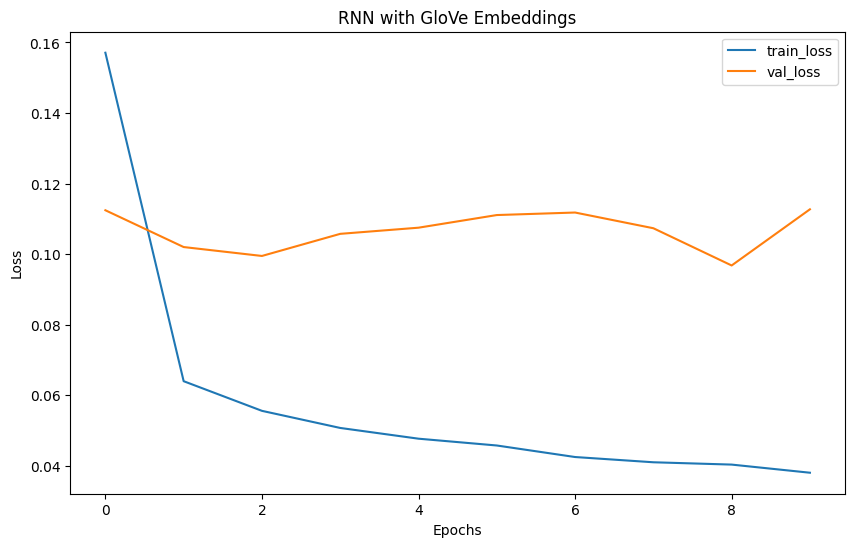

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8830 - loss: 0.3501 - val_accuracy: 0.9648 - val_loss: 0.1049
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9739 - loss: 0.0790 - val_accuracy: 0.9682 - val_loss: 0.1000
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9779 - loss: 0.0660 - val_accuracy: 0.9697 - val_loss: 0.0965
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9818 - loss: 0.0556 - val_accuracy: 0.9702 - val_loss: 0.1025
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9835 - loss: 0.0500 - val_accuracy: 0.9710 - val_loss: 0.1034
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9846 - loss: 0.0474 - val_accuracy: 0.9704 - val_loss: 0.1105
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9844 - loss: 0.0477 - val_accuracy: 0.9708 - val_loss: 0.1218
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9866 - loss: 0.0417 - val_accuracy: 0.9708 - 

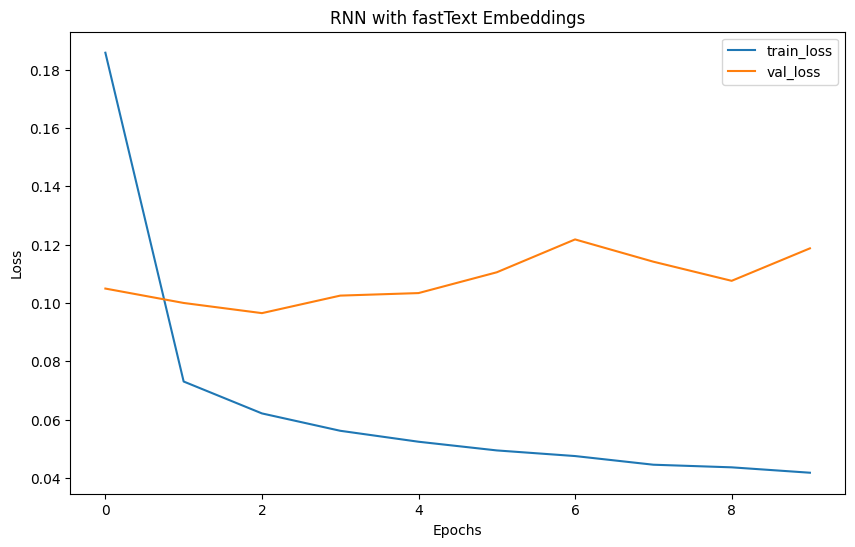

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9339 - loss: 0.5784 - val_accuracy: 0.9691 - val_loss: 0.1127
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9816 - loss: 0.0590 - val_accuracy: 0.9702 - val_loss: 0.1128
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9834 - loss: 0.0531 - val_accuracy: 0.9710 - val_loss: 0.1101
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9855 - loss: 0.0483 - val_accuracy: 0.9714 - val_loss: 0.1034
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9865 - loss: 0.0452 - val_accuracy: 0.9715 - val_loss: 0.1124
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9872 - loss: 0.0421 - val_accuracy: 0.9715 - val_loss: 0.1102
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9875 - loss: 0.0395 - val_accuracy: 0.9713 - val_loss: 0.1208
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9881 - loss: 0.0386 - val_accuracy: 0.9709 - 

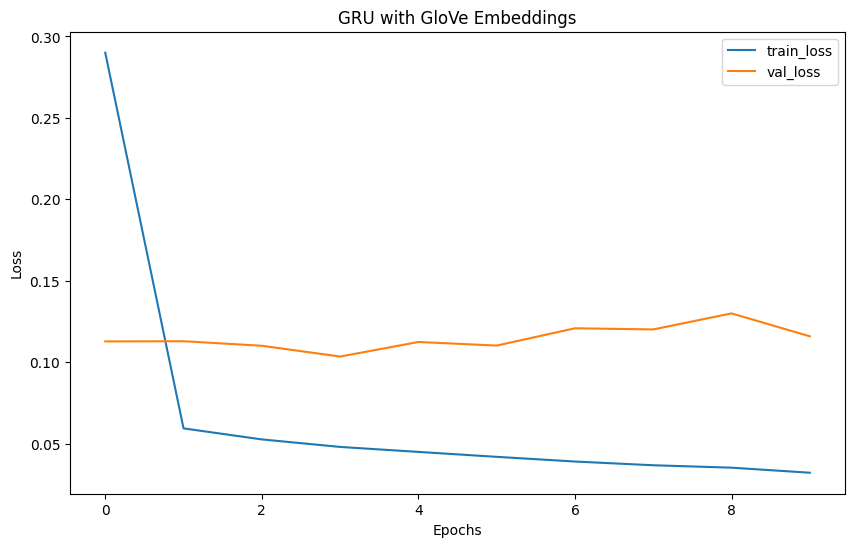

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9244 - loss: 0.6102 - val_accuracy: 0.9649 - val_loss: 0.1041
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9754 - loss: 0.0711 - val_accuracy: 0.9681 - val_loss: 0.0992
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9808 - loss: 0.0588 - val_accuracy: 0.9705 - val_loss: 0.1007
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9820 - loss: 0.0557 - val_accuracy: 0.9717 - val_loss: 0.1034
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9834 - loss: 0.0512 - val_accuracy: 0.9717 - val_loss: 0.1074
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9841 - loss: 0.0491 - val_accuracy: 0.9716 - val_loss: 0.1102
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9850 - loss: 0.0469 - val_accuracy: 0.9712 - val_loss: 0.1161
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9858 - loss: 0.0461 - val_accuracy: 0.9718 - 

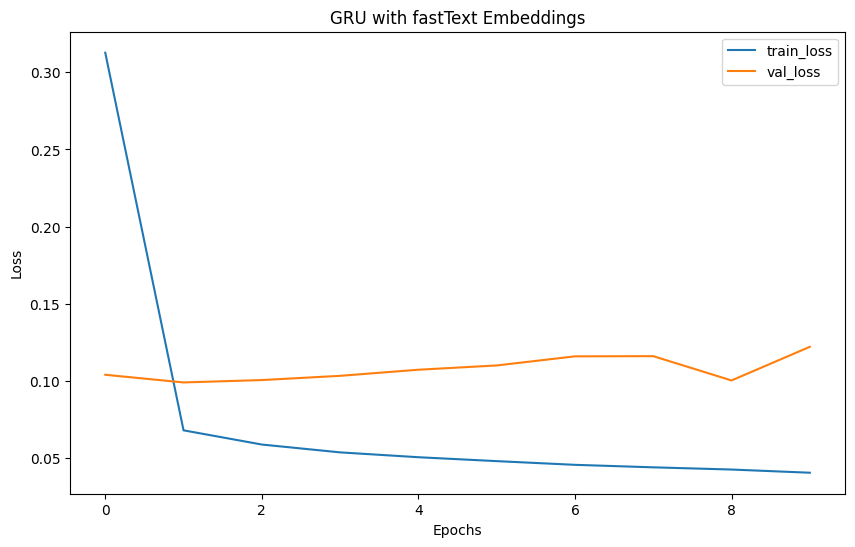

In [26]:
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, GRU, TimeDistributed, Dense, Dropout

# Train the RNN model with GloVe embeddings
rnn_glove_model = create_rnn_model(glove_embedding_matrix, max_len, embedding_dim_glove)
history_rnn_glove = rnn_glove_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss(history_rnn_glove, 'RNN with GloVe Embeddings')

# Train the RNN model with fastText embeddings
rnn_fasttext_model = create_rnn_model(fasttext_embedding_matrix, max_len, embedding_dim_fasttext)
history_rnn_fasttext = rnn_fasttext_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss(history_rnn_fasttext, 'RNN with fastText Embeddings')

# Train the GRU model with GloVe embeddings
gru_glove_model = create_gru_model(glove_embedding_matrix, max_len, embedding_dim_glove)
history_gru_glove = gru_glove_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss(history_gru_glove, 'GRU with GloVe Embeddings')

# Train the GRU model with fastText embeddings
gru_fasttext_model = create_gru_model(fasttext_embedding_matrix, max_len, embedding_dim_fasttext)
history_gru_fasttext = gru_fasttext_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss(history_gru_fasttext, 'GRU with fastText Embeddings')

In [ ]:
from conlleval import evaluate

In [11]:
# now i want what i trained the model , i need my y_pred , 
y_pred_labels = rnn_glove_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step


In [12]:
y_pred_labels

array([[[2.5729055e-04, 9.0767091e-05, 9.9965191e-01],
        [1.8818553e-05, 8.3600167e-07, 9.9998033e-01],
        [1.1434376e-04, 1.6876251e-06, 9.9988401e-01],
        ...,
        [9.9999607e-01, 1.5020695e-06, 2.3797502e-06],
        [9.9999416e-01, 2.4312897e-06, 3.4612747e-06],
        [9.9999166e-01, 3.6453671e-06, 4.6975583e-06]],

       [[1.6949983e-01, 1.7595289e-02, 8.1290489e-01],
        [7.4290098e-03, 3.8300171e-03, 9.8874098e-01],
        [4.4013775e-04, 2.4298189e-04, 9.9931681e-01],
        ...,
        [9.9999607e-01, 1.5020710e-06, 2.3797547e-06],
        [9.9999416e-01, 2.4312874e-06, 3.4612681e-06],
        [9.9999166e-01, 3.6453671e-06, 4.6975583e-06]],

       [[1.0212652e-04, 6.8821469e-06, 9.9989092e-01],
        [1.3673605e-05, 8.1450274e-08, 9.9998617e-01],
        [4.8855462e-05, 1.6637895e-06, 9.9994946e-01],
        ...,
        [9.9999607e-01, 1.5020725e-06, 2.3797547e-06],
        [9.9999416e-01, 2.4312874e-06, 3.4612713e-06],
        [9.9999166e-01

In [13]:
# The shape (304, 69, 3) tells us that:

# You have 304 sentences in your validation data.
# The maximum sentence length in your validation data is 69 words (including padding).
# Your model is predicting probabilities for 3 different classes ('O', 'B', 'I') for each word in each sentence
y_pred_labels.shape

(304, 69, 3)

In [57]:
import numpy as np
from conlleval import evaluate

def prepare_sequences_for_evaluation(y_pred, y_true, idx2tag):
    """
    Prepare sequences for conlleval.evaluate function
    
    Args:
        y_pred: Model predictions
        y_true: True labels
        idx2tag: Mapping from indices to tags
        
    Returns:
        Lists of true and predicted tag sequences
    """
    # Flatten sequences for conlleval format
    true_seqs = []
    pred_seqs = []
    
    for i in range(len(y_true)):
        # Convert predictions to tag indices
        pred_indices = np.argmax(y_pred[i], axis=-1)
        true_indices = y_true[i]
        
        # Get actual sequence length (ignoring padding with value 0)
        valid_indices = np.where(true_indices > 0)[0]
        if len(valid_indices) > 0:
            seq_len = valid_indices[-1] + 1
        else:
            seq_len = len(true_indices)
        
        # Convert to BIO tags with entity type
        true_seq = []
        pred_seq = []
        
        for j in range(seq_len):
            # Handle true tags
            if true_indices[j] > 0:  # Skip padding
                tag = idx2tag[int(true_indices[j])]
                if tag == 'B':
                    true_seq.append('B-ASPECT')
                elif tag == 'I':
                    true_seq.append('I-ASPECT')
                else:  # 'O'
                    true_seq.append('O')
            
            # Handle predicted tags
            pred_tag = idx2tag[int(pred_indices[j])]
            if pred_tag == 'B':
                pred_seq.append('B-ASPECT')
            elif pred_tag == 'I':
                pred_seq.append('I-ASPECT')
            else:  # 'O' or 'PAD'
                pred_seq.append('O')
        
        # Only include non-empty sequences
        if true_seq and pred_seq:
            true_seqs.append(true_seq)
            pred_seqs.append(pred_seq)
    
    return true_seqs, pred_seqs

In [58]:
def calculate_f1_scores(model, X_val, y_val, idx2tag):
    """
    Calculate F1 scores using conlleval
    
    Args:
        model: Trained model
        X_val: Validation features
        y_val: True labels
        idx2tag: Mapping from indices to BIO tags
        
    Returns:
        Dictionary with tag-level and chunk-level F1 scores
    """
    # Get model predictions
    print("Making predictions...")
    y_pred = model.predict(X_val)
    
    # Prepare sequences for evaluation
    print("Preparing sequences for evaluation...")
    true_seqs, pred_seqs = prepare_sequences_for_evaluation(y_pred, y_val, idx2tag)
    
    # Print example for debugging
    if true_seqs and pred_seqs:
        print(f"Example true sequence: {true_seqs[0][:10]}")
        print(f"Example pred sequence: {pred_seqs[0][:10]}")
    
    # Flatten all sequences for conlleval
    true_tags = []
    pred_tags = []
    
    for true_seq, pred_seq in zip(true_seqs, pred_seqs):
        # Make sure sequences are the same length
        min_len = min(len(true_seq), len(pred_seq))
        true_tags.extend(true_seq[:min_len])
        pred_tags.extend(pred_seq[:min_len])
    
    # Call the evaluate function
    print(f"Evaluating {len(true_seqs)} sequences...")
    result = evaluate(true_tags, pred_tags, verbose=True)
    
    # Extract metrics from result
    tag_level_f1 = result[2]  # F1 score is the third item in the returned tuple
    
    # Calculate chunk-level F1 by running evaluate on each sequence pair separately
    chunk_level_results = []
    for i in range(len(true_seqs)):
        try:
            # Evaluate single sequence
            seq_result = evaluate(true_seqs[i], pred_seqs[i], verbose=False)
            if seq_result[2] > 0:  # Only include non-zero F1 scores
                chunk_level_results.append(seq_result[2])
        except:
            # Skip sequences that cause errors
            pass
    
    # Calculate average chunk-level F1
    chunk_level_f1 = sum(chunk_level_results) / len(chunk_level_results) if chunk_level_results else 0.0
    
    print(f"\nEvaluation Results:")
    print(f"  Tag-level F1: {tag_level_f1:.4f}")
    print(f"  Chunk-level F1: {chunk_level_f1:.4f}")
    
    return {
        'tag_level_f1': tag_level_f1,
        'chunk_level_f1': chunk_level_f1,
        'full_result': result
    }

In [59]:
# Define idx2tag mapping
idx2tag = {
    0: 'PAD',  # Padding token
    1: 'O',    # Outside tag
    2: 'B',    # Beginning of aspect term
    3: 'I'     # Inside aspect term
}

# Define models dictionary
models = {
    'RNN with GloVe': rnn_glove_model,
    'RNN with fastText': rnn_fasttext_model,
    'GRU with GloVe': gru_glove_model,
    'GRU with fastText': gru_fasttext_model
}

# Evaluate all models
print("Evaluating models...")
evaluation_results = {}

for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")
    results = calculate_f1_scores(model, X_val, y_val, idx2tag)
    evaluation_results[name] = results
    
    print(f"\n{name} Performance:")
    print(f"  Tag-level F1: {results['tag_level_f1']:.4f}")
    print(f"  Chunk-level F1: {results['chunk_level_f1']:.4f}")

# Create a comparison table
import pandas as pd

# Prepare data for the table
comparison_data = []

for name, results in evaluation_results.items():
    comparison_data.append({
        'Model': name,
        'Tag-level F1': results['tag_level_f1'],
        'Chunk-level F1': results['chunk_level_f1']
    })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the table
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Save to CSV for report
comparison_df.to_csv('model_comparison.csv', index=False)

Evaluating models...

=== Evaluating RNN with GloVe ===
Making predictions...
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Preparing sequences for evaluation...
Example true sequence: ['B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT']
Example pred sequence: ['B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT']
Evaluating 304 sequences...
processed 3913 tokens with 3802 phrases; found: 3464 phrases; correct: 3422.
accuracy:  90.01%; (non-O)
accuracy:  89.22%; precision:  98.79%; recall:  90.01%; FB1:  94.19
           ASPECT: precision:  98.79%; recall:  90.01%; FB1:  94.19  3464

Evaluation Results:
  Tag-level F1: 94.1921
  Chunk-level F1: 92.6930

RNN with GloVe Performance:
  Tag-level F1: 94.1921
  Chunk-level F1: 92.6930

=== Evaluating RNN with fastText ===
Making predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\dhair\AppData\Local\Temp\ipykernel_7060\3336201800.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tag = idx2tag[int(true_indices[j])]


Preparing sequences for evaluation...
Example true sequence: ['B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT']
Example pred sequence: ['B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT']
Evaluating 304 sequences...
processed 3913 tokens with 3802 phrases; found: 3463 phrases; correct: 3415.
accuracy:  89.82%; (non-O)
accuracy:  88.88%; precision:  98.61%; recall:  89.82%; FB1:  94.01
           ASPECT: precision:  98.61%; recall:  89.82%; FB1:  94.01  3463

Evaluation Results:
  Tag-level F1: 94.0124
  Chunk-level F1: 92.5595

RNN with fastText Performance:
  Tag-level F1: 94.0124
  Chunk-level F1: 92.5595

=== Evaluating GRU with GloVe ===
Making predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Preparing sequences for evaluation...
Example true sequence: ['B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-A

In [60]:
# Find best model based on chunk-level F1 score
best_model_name = max(evaluation_results, 
                      key=lambda k: evaluation_results[k]['chunk_level_f1'])
best_model = models[best_model_name]
best_chunk_f1 = evaluation_results[best_model_name]['chunk_level_f1']
best_tag_f1 = evaluation_results[best_model_name]['tag_level_f1']

print(f"\nBest Model: {best_model_name}")
print(f"  Tag-level F1: {best_tag_f1:.4f}")
print(f"  Chunk-level F1: {best_chunk_f1:.4f}")

# Save the best model
best_model.save('best_model.h5')

# Save model information for inference
import pickle
model_info = {
    'model_name': best_model_name,
    'idx2tag': idx2tag,
    'max_len': max_len,  # Make sure this is defined
    'tag_level_f1': best_tag_f1,
    'chunk_level_f1': best_chunk_f1
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print(f"\nBest model ({best_model_name}) saved to best_model.h5")
print("Model information saved to model_info.pkl")


Best Model: RNN with GloVe
  Tag-level F1: 94.1921
  Chunk-level F1: 92.6930

Best model (RNN with GloVe) saved to best_model.h5
Model information saved to model_info.pkl


In [64]:
import json
import numpy as np
import pickle
from collections import defaultdict, Counter

def recreate_word2idx():
    """Recreate word2idx mapping from training data"""
    print("Recreating word2idx mapping from training data...")
    
    # Load your training data
    with open('train_task_1.json', 'r', encoding='utf-8') as f:
        train_data = json.load(f)
    
    # Count word frequencies
    word_counts = Counter()
    
    for entry in train_data:
        # Use the same tokenization as in your training
        tokens = entry['sentence'].split()
        for token in tokens:
            word_counts[token.lower()] += 1
    
    # Create word2idx mapping (similar to your original preprocessing)
    # Start with special tokens
    word2idx = {
        '<PAD>': 0,  # Padding token
        '<UNK>': 1   # Unknown token
    }
    
    # Add all words that appear at least once
    idx = 2  # Start after special tokens
    for word, count in word_counts.most_common():
        word2idx[word] = idx
        idx += 1
    
    # Save the recreated mapping
    with open('word2idx.pkl', 'wb') as f:
        pickle.dump(word2idx, f)
    
    print(f"Created word2idx with {len(word2idx)} entries")
    print(f"First few entries: {list(word2idx.items())[:5]}")
    
    return word2idx

# Recreate and save the word2idx mapping
word2idx = recreate_word2idx()

Recreating word2idx mapping from training data...
Created word2idx with 5763 entries
First few entries: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('and', 3), ('a', 4)]


In [65]:
def test_model_on_file(test_file_path):
    """
    Function that:
    1. Loads the trained model
    2. Processes the test.json file
    3. Returns F1-scores using conlleval evaluate function
    
    Args:
        test_file_path: Path to test.json file
        
    Returns:
        Dictionary with F1 scores
    """
    import json
    import numpy as np
    from tensorflow.keras.models import load_model
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from conlleval import evaluate
    import pickle
    
    print(f"Testing model on {test_file_path}")
    
    try:
        # 1. Load the model and model info
        print("Loading model and model information...")
        model = load_model('best_model.h5')
        
        with open('model_info.pkl', 'rb') as f:
            model_info = pickle.load(f)
        
        idx2tag = model_info['idx2tag']
        max_len = model_info['max_len']
        
        # 2. Load the test file
        print(f"Loading and processing {test_file_path}...")
        with open(test_file_path, 'r', encoding='utf-8') as f:
            test_data = json.load(f)
        
        # 3. Process the test data
        # Load word2idx mapping if needed
        with open('word2idx.pkl', 'rb') as f:
            word2idx = pickle.load(f)
        
        # Initialize containers
        X_test = []
        y_test = []
        
        # Process each example
        for entry in test_data:
            # Get tokens and convert to BIO labels
            tokens = entry['sentence'].split()
            
            # Create BIO labels based on aspect terms
            aspect_terms = entry.get('aspect_terms', [])
            labels = ['O'] * len(tokens)
            
            for aspect in aspect_terms:
                term = aspect['term']
                start = int(aspect['from'])
                end = int(aspect['to'])
                
                # Find token indices that correspond to this aspect
                token_start = 0
                token_idx = 0
                
                for i, token in enumerate(tokens):
                    if token_start <= start < token_start + len(token):
                        # First token of aspect
                        labels[i] = 'B'
                        token_idx = i + 1
                        break
                    token_start += len(token) + 1  # +1 for space
                
                # Continue for multi-token aspects
                while token_idx < len(tokens) and token_start < end:
                    token_start += len(tokens[token_idx-1]) + 1
                    if token_start < end:
                        labels[token_idx] = 'I'
                    token_idx += 1
            
            # Convert tokens to indices
            token_indices = []
            for token in tokens:
                if token.lower() in word2idx:
                    token_indices.append(word2idx[token.lower()])
                else:
                    token_indices.append(word2idx.get('<UNK>', 1))
            
            # Convert labels to indices
            label_indices = []
            for label in labels:
                if label == 'O':
                    label_indices.append(1)
                elif label == 'B':
                    label_indices.append(2)
                elif label == 'I':
                    label_indices.append(3)
                else:
                    label_indices.append(0)  # Unknown
            
            X_test.append(token_indices)
            y_test.append(label_indices)
        
        # 4. Pad sequences
        X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')
        y_test_padded = pad_sequences(y_test, maxlen=max_len, padding='post')
        
        # 5. Make predictions
        print("Making predictions...")
        y_pred = model.predict(X_test_padded)
        
        # 6. Convert to BIO tags for evaluation
        print("Preparing sequences for evaluation...")
        true_tags_all = []
        pred_tags_all = []
        
        for i in range(len(y_test_padded)):
            # Get predictions for this sequence
            pred = np.argmax(y_pred[i], axis=-1)
            true = y_test_padded[i]
            
            # Find actual sequence length (non-padding)
            seq_length = 0
            for j in range(len(true)):
                if true[j] > 0:  # Non-padding
                    seq_length = j + 1
            
            if seq_length == 0:
                seq_length = len(true)
            
            # Convert to BIO tags with entity types
            true_tags = []
            pred_tags = []
            
            for j in range(seq_length):
                if true[j] > 0:  # Skip padding
                    t_tag = idx2tag[int(true[j])]
                    if t_tag == 'B':
                        true_tags.append('B-ASPECT')
                    elif t_tag == 'I':
                        true_tags.append('I-ASPECT')
                    else:
                        true_tags.append('O')
                
                p_tag = idx2tag[int(pred[j])]
                if p_tag == 'B':
                    pred_tags.append('B-ASPECT')
                elif p_tag == 'I':
                    pred_tags.append('I-ASPECT')
                else:
                    pred_tags.append('O')
            
            # Only add if we have valid tags
            if true_tags and pred_tags:
                true_tags_all.append(true_tags)
                pred_tags_all.append(pred_tags)
        
        # Print sample for debugging
        if true_tags_all and pred_tags_all:
            print(f"Sample true tags: {true_tags_all[0][:10]}")
            print(f"Sample pred tags: {pred_tags_all[0][:10]}")
        
        # 7. Flatten for conlleval
        all_true_tags = []
        all_pred_tags = []
        
        for true_seq, pred_seq in zip(true_tags_all, pred_tags_all):
            # Make sure sequences are the same length
            min_len = min(len(true_seq), len(pred_seq))
            all_true_tags.extend(true_seq[:min_len])
            all_pred_tags.extend(pred_seq[:min_len])
        
        # 8. Calculate F1 scores
        print(f"Evaluating {len(true_tags_all)} sequences...")
        results = evaluate(all_true_tags, all_pred_tags, verbose=True)
        
        # Extract F1 scores
        tag_level_f1 = results[2]  # F1 score is the third item in the returned tuple
        
        # Calculate chunk-level F1
        chunk_f1_values = []
        for true_seq, pred_seq in zip(true_tags_all, pred_tags_all):
            try:
                # Evaluate single sequence
                chunk_result = evaluate(true_seq, pred_seq, verbose=False)
                if chunk_result[2] > 0:  # Only include non-zero F1
                    chunk_f1_values.append(chunk_result[2])
            except:
                pass
        
        chunk_level_f1 = sum(chunk_f1_values) / len(chunk_f1_values) if chunk_f1_values else 0.0
        
        # 9. Return results
        print(f"\nTest Results:")
        print(f"  Tag-level F1: {tag_level_f1:.4f}")
        print(f"  Chunk-level F1: {chunk_level_f1:.4f}")
        
        return {
            'tag_level_f1': tag_level_f1,
            'chunk_level_f1': chunk_level_f1
        }
    
    except Exception as e:
        print(f"Error in testing: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'tag_level_f1': 0.0,
            'chunk_level_f1': 0.0,
            'error': str(e)
        }

# this is the function to pass test.json file

In [66]:
def demo_test_function(test_file='test.json'):
    """Complete demo function that handles all prerequisites"""
    import os
    
    # Check if required files exist
    if not os.path.exists('best_model.h5'):
        print("Error: best_model.h5 not found!")
        return None
        
    if not os.path.exists('model_info.pkl'):
        print("Error: model_info.pkl not found!")
        return None
    
    # Check if word2idx exists, recreate if needed
    if not os.path.exists('word2idx.pkl'):
        print("word2idx.pkl not found, recreating from training data...")
        recreate_word2idx()
    
    # Call the test function
    print(f"\n=== RUNNING DEMO ON {test_file} ===\n")
    results = test_model_on_file(test_file)
    
    print("\n=== TEST SUMMARY ===")
    print(f"Tag-level F1: {results['tag_level_f1']:.4f}")
    print(f"Chunk-level F1: {results['chunk_level_f1']:.4f}")
    
    return results

<!-- Pass the test.json file here to check the results -->

In [67]:
# Call the demo function with test.json
results = demo_test_function('test.json')

# Print results
if results:
    print("\nTest Results:")
    print(f"Tag-level F1: {results['tag_level_f1']:.4f}")
    print(f"Chunk-level F1: {results['chunk_level_f1']:.4f}")
else:
    print("Test failed. Check error messages above.")


=== RUNNING DEMO ON test.json ===

Testing model on test.json
Loading model and model information...
Loading and processing test.json...
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Preparing sequences for evaluation...
Sample true tags: ['O', 'B-ASPECT', 'O', 'O', 'O', 'B-ASPECT', 'I-ASPECT', 'O', 'O', 'O']
Sample pred tags: ['B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT', 'B-ASPECT']
Evaluating 2 sequences...
processed 20 tokens with 4 phrases; found: 19 phrases; correct: 1.
accuracy:  50.00%; (non-O)
accuracy:  15.00%; precision:   5.26%; recall:  25.00%; FB1:   8.70
           ASPECT: precision:   5.26%; recall:  25.00%; FB1:   8.70  19

Test Results:
  Tag-level F1: 8.6957
  Chunk-level F1: 16.6667

=== TEST SUMMARY ===
Tag-level F1: 8.6957
Chunk-level F1: 16.6667

Test Results:
Tag-level F1: 8.6957
Chunk-level F1: 16.6667
